<a href="https://colab.research.google.com/github/element-fi/elf-simulations/blob/main/examples/notebooks/hyperdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperdrive Simulation
We use the following setup:
- 90 day term
- 200 agents, 100 randomly open and close longs, the other 100 randomly open and close shorts
- agents are initialized with 1 million of capital, trading 10% of their budget per trade
- they trade at random intervals calibrated to be roughly twice per term (1 open 1 close)
- there is one Liquidity Provider which deposits 500 million of liquidity

For details on the simulation framework, please see our <a href="https://elfpy.element.fi/">simulation documentation</a>

### Install repo requirements & import packages

In [ ]:
# test: skip-cell
try: # install dependencies only if running on google colab
    import google.colab # check if running in colab
    !pip install -r https://raw.githubusercontent.com/element-fi/elf-simulations/main/requirements-3.8.txt 
    !pip install git+https://github.com/element-fi/elf-simulations.git
except:
    print("running locally & trusting that you have the dependencies installed")

In [ ]:
from __future__ import annotations

import numpy as np
from numpy.random._generator import Generator
import matplotlib.pyplot as plt
import pandas as pd

from elfpy import WEI
from elfpy.agents.agent import Agent
from elfpy.utils import sim_utils
from elfpy.simulators import Config
from elfpy.utils.outputs import get_gridspec_subplots

import elfpy.markets.hyperdrive as hyperdrive
import elfpy.types as types
import elfpy.utils.outputs as output_utils
import elfpy.utils.post_processing as post_processing

### Setup experiment parameters

In [ ]:
config = Config()

config.title = "Hyperdrive demo"
config.pricing_model_name = "Hyperdrive" # can be yieldspace or hyperdrive

config.num_trading_days = 90 # Number of simulated trading days
config.num_position_days = config.num_trading_days
config.num_blocks_per_day = 10 #7200 # Blocks in a given day (7200 means ~12 sec per block)
config.trade_fee_percent = 0.10 # fee percent collected on trades
config.redemption_fee_percent = 0.005 # 5 bps

num_agents = 100 # int specifying how many agents you want to simulate
agent_budget = 1_000_000 # max money an agent can spend
trade_chance = 2 / (config.num_trading_days * config.num_blocks_per_day) # on a given block, an agent will trade with probability `trade_chance`

config.target_fixed_apr = 0.01 # target fixed APR of the initial market after the LP
config.target_liquidity = 500_000_000 # target total liquidity of the initial market, before any trades

config.log_level = output_utils.text_to_log_level("WARNING") # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
config.log_filename = "hyperdrive" # Output filename for logging

### Setup agents

In [ ]:
class RandomAgent(Agent):
    """
    Agent that randomly opens or closes longs or shorts
    """

    def __init__(self, rng: Generator, trade_chance: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_long = True  # default to allow easy overriding
        self.trade_short = True  # default to allow easy overriding
        self.trade_chance = trade_chance
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: hyperdrive.Market) -> list[hyperdrive.MarketAction]:
        """Implement a random user strategy

        The agent performs one of four possible trades:
            [OPEN_LONG, OPEN_SHORT, CLOSE_LONG, CLOSE_SHORT]
            with the condition that close actions can only be performed after open actions

        The amount opened and closed is random, within constraints given by agent budget & market reserve levels

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        # User can always open a trade, and can close a trade if one is open
        available_actions = []
        if self.trade_long is True:
            available_actions+=[hyperdrive.MarketActionType.OPEN_LONG]
        if self.trade_short is True:
            available_actions+=[hyperdrive.MarketActionType.OPEN_SHORT]
        has_opened_short = bool(any((short.balance > 0 for short in self.wallet.shorts.values())))
        if has_opened_short:
            available_actions = [hyperdrive.MarketActionType.CLOSE_SHORT]
        has_opened_long = bool(any((long.balance > 0 for long in self.wallet.longs.values())))
        if has_opened_long:
            available_actions = [hyperdrive.MarketActionType.CLOSE_LONG]
        action_type = self.rng.choice(available_actions, size=1) # choose one random trade type
        # trade amount is also randomly chosen
        if action_type == hyperdrive.MarketActionType.OPEN_SHORT:
            random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
            max_short = self.get_max_short(market)
            if max_short > WEI: # if max_short is greater than the minimum eth amount
                trade_amount = np.maximum(WEI, np.minimum(max_short, random_normal)) # WEI <= trade_amount <= max_short
                action_list = [
                    types.Trade(
                        market=types.MarketType.HYPERDRIVE,
                        trade=hyperdrive.MarketAction(
                            action_type=action_type,
                            trade_amount=trade_amount,
                            wallet=self.wallet,
                            mint_time=market.time
                        )
                    )
                ]
            else: # no short is possible
                action_list = []
        elif action_type == hyperdrive.MarketActionType.OPEN_LONG:
            random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
            max_long = self.get_max_long(market)
            if max_long > WEI: # if max_long is greater than the minimum eth amount
                trade_amount = np.maximum(WEI, np.minimum(max_long, random_normal))
                action_list = [
                    types.Trade(
                        market=types.MarketType.HYPERDRIVE,
                        trade=hyperdrive.MarketAction(
                            action_type=action_type,
                            trade_amount=trade_amount,
                            wallet=self.wallet,
                            mint_time=market.time,
                        )
                    )
                ]
            else:
                action_list = []
        elif action_type == hyperdrive.MarketActionType.CLOSE_SHORT:
            short_time = self.rng.choice(list(self.wallet.shorts))
            trade_amount = self.wallet.shorts[short_time].balance # close the full trade
            open_share_price = self.wallet.shorts[short_time].open_share_price
            action_list = [
                types.Trade(
                    market=types.MarketType.HYPERDRIVE,
                    trade=hyperdrive.MarketAction(
                        action_type=action_type,
                        trade_amount=trade_amount,
                        wallet=self.wallet,
                        mint_time=short_time
                    )
                )
            ]
        elif action_type == hyperdrive.MarketActionType.CLOSE_LONG:
            long_time = self.rng.choice(list(self.wallet.longs))
            trade_amount = self.wallet.longs[long_time].balance # close the full trade
            action_list = [
                types.Trade(
                    market=types.MarketType.HYPERDRIVE,
                    trade=hyperdrive.MarketAction(
                        action_type=action_type,
                        trade_amount=trade_amount,
                        wallet=self.wallet,
                        mint_time=long_time,
                    )
                )
            ]
        else:
            action_list = []
        return action_list


def get_example_agents(rng: Generator, budget: int, new_agents: int, existing_agents: int = 0, direction: str = None) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + new_agents):
        agent = RandomAgent(
            rng=rng,
            trade_chance=trade_chance,
            wallet_address=address,
            budget=budget,
        )
        if direction is not None:
            if direction == "short":
                agent.trade_long = False
            elif direction == "long":
                agent.trade_short = False
        agent.log_status_report()
        agents += [agent]
    return agents


### Define variable apr process

In [ ]:
def DSR_historical(num_dates=90):
    dsr = pd.read_csv('https://s3-sim-repo-0.s3.us-east-2.amazonaws.com/Data/HIST_DSR_D.csv', index_col=0, infer_datetime_format=True)
    dsr.index = pd.to_datetime(dsr.index)
    dsr = dsr.resample('D').mean()
    min_date = dsr.index.min()
    max_date = dsr.index.max()
    date_range = max_date - min_date
    new_date_range = min_date + date_range * np.linspace(0, 1, num_dates)
    dsr_new = dsr.reindex(new_date_range, method='ffill')
    dsr_new = dsr_new.reset_index(drop=True)
    return dsr_new["DAI_SAV_RATE"].to_list()

# Define the variable apr
config.variable_apr = DSR_historical(num_dates=config.num_trading_days)
config.freeze() # type: ignore

### Setup simulation objects

In [ ]:
# define root logging parameters
output_utils.setup_logging(log_filename=config.log_filename, log_level=config.log_level)

# get an instantiated simulator object
simulator = sim_utils.get_simulator(config)
print(config.target_fixed_apr)
print(config.num_position_days)
print(simulator.market.spot_price)
print(simulator.market.fixed_apr)
print(simulator.market.market_state.share_reserves)
print(simulator.market.market_state.bond_reserves)

### Run the simulation

In [ ]:
# add the random agents
short_agents = get_example_agents(rng=simulator.rng, budget=agent_budget, new_agents=num_agents, existing_agents=1, direction="short")
long_agents = get_example_agents(rng=simulator.rng, budget=agent_budget, new_agents=num_agents, existing_agents=1+num_agents, direction="long")
simulator.add_agents(short_agents + long_agents)
print(f"Simulator has {len(simulator.agents)} agents")

# run the simulation
simulator.run_simulation()

In [ ]:
# convert simulation state to a pandas dataframe
trades = post_processing.compute_derived_variables(simulator)
for col in trades:
    if col.startswith("agent"):
        divisor = 1e6 # 1 million divisor for everyone
        trades[col] = trades[col] / divisor

### Plot simulation results

This shows the evolution of interest rates over time. The "variable" APR represents a theoretical underlying variable rate. Here we've mocked it up to have the same pattern as the MakerDao DAI Saving Rate over its whole history, but condensed to a 90 day period for this simulation. The fixed rate is initialized at 1% and appears to remain unchanged.

In [ ]:
trades_agg = trades.groupby("day").agg(
    {
        "variable_apr": ["mean"],
        "fixed_apr": ["mean"],
        "delta_base_abs": ["sum"],
        "agent_0_pnl": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
ax = get_gridspec_subplots()[1][0]
plt.gcf().set_size_inches(6,5)
ax = trades_agg.iloc[0:].plot(x="day", y="variable_apr_mean", ax=ax, label="variable", c='blue')
ax = trades_agg.iloc[0:].plot(x="day", y="fixed_apr_mean", ax=ax, label="fixed", c='black')
ax.set_title("Interest rates over time")
ax.set_xlabel("Day")
ax.set_ylabel("APR")
ax.legend()

xtick_step = 10
ax.set_xticks([0]+[x for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ax.set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_yticks([i for i in np.arange(ylim[0], ylim[1], 0.01)])
ax.set_yticklabels([f"{(i):.0%}" for i in ax.get_yticks()]);

It may look like the black line isn't moving at all, until the end. But let's zoom in!

This is a function of two things: random agents being too dumb to concertedly move the rate, as well as the model parameters not being optimized for this scenario.

In [ ]:
fig = output_utils.plot_fixed_apr(trades, exclude_first_day=True, exclude_last_day = True)
fig.set_size_inches(6,5)
ax = plt.gca()
ax.properties()['children'][0].set_color('black')
ax.set_yticklabels([f"{(i/100):.3%}" for i in ax.get_yticks()])
ax.set_ylabel("APR")

xtick_step = 10
ax.set_xticks([0]+[x for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ax.set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.num_trading_days + 1, xtick_step)]);

These random agents are unable to pick smart entry points. Due to trading on coinflips only, they slowdly bleed fees out of their starting position, which in this case reduces from 1.0 million down to 0.999, a loss of $1k.

In [ ]:
def get_pnl_excluding_agent_0_no_mock_with_day(trades_df: pd.DataFrame) -> pd.DataFrame:
    """Returns Profit and Loss Column for every agent except for agent 0 from post-processing"""
    cols_to_return = ['day']+[col for col in trades_df if col.startswith("agent") and col.endswith("pnl_no_mock")]
    cols_to_return.remove("agent_0_pnl_no_mock")
    return trades_df[cols_to_return]

def plot_pnl(pnl, ax, label, last_day):
    # ax.plot(pnl.iloc[1:,:], linestyle='-', linewidth=0.5, alpha=0.5)
    # separate first half of agents, which are set to trade short
    # from second half of agents, which are set to trade long
    columns = pnl.columns.to_list()
    n = int(len(columns)/2)
    short_pnl = pnl.loc[1:, columns[:n]].mean(axis=1)
    long_pnl = pnl.loc[1:, columns[n:]].mean(axis=1)
    ax.plot(short_pnl, c='red', label=f"Short {label}, final value={short_pnl[len(short_pnl)]:.5f}", linewidth=2)
    ax.plot(long_pnl, c='black', label=f"Long {label}, final_value={long_pnl[len(long_pnl)]:.5f}", linewidth=2)
    # grey area where day is last day
    ax.set_ylabel('PNL in millions')
    # ax.axvspan(last_day, len(short_pnl), color='grey', alpha=0.2, label="Last day")
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True, gridspec_kw={'wspace': 0.0, 'hspace': 0.0})
first_trade_that_is_on_last_day = min(trades.index[trades.day == max(trades.day)])
# data_mock = post_processing.get_pnl_excluding_agent_0(trades)
data_no_mock = get_pnl_excluding_agent_0_no_mock_with_day(trades).groupby('day').mean()
# plot_pnl(pnl=data_mock,label='Mock',ax=ax[0],last_day=first_trade_that_is_on_last_day)
plot_pnl(pnl=data_no_mock,label='Realized Market Value',ax=ax,last_day=first_trade_that_is_on_last_day)

xtick_step = 10
ax.set_xticks([0]+[x for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ax.set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])

plt.gca().set_xlabel("Day")
plt.gca().set_title('Trader PNL over time');
# display(data_no_mock)

This plot shows being a Liquidity Provider (LP) is a profitable position, in this scenario where agents are trading randomly.

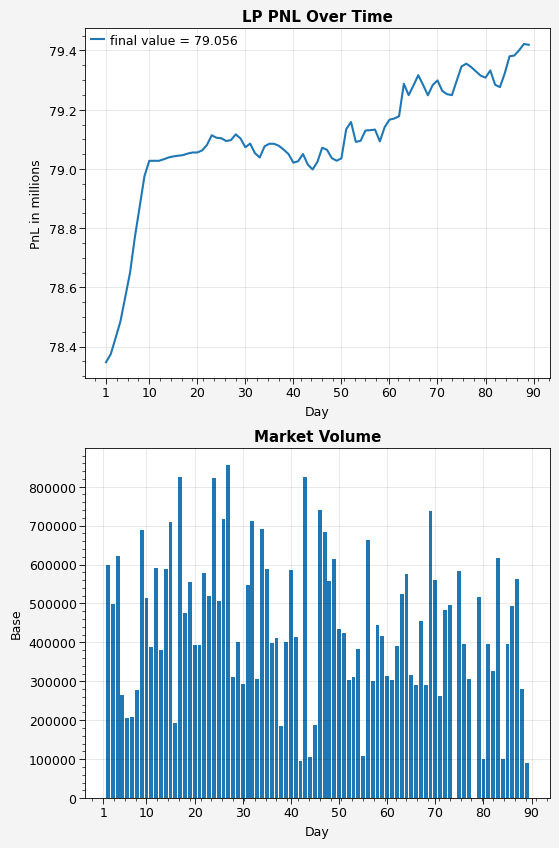

In [12]:
fig, ax = plt.subplots(2,1,figsize=(6, 10))
exclude_last_day = True
num_agents = 1
start_idx = 0
first_trade_that_is_on_last_day = min(trades_agg.index[trades_agg.day == max(trades_agg.day)])
end_idx = first_trade_that_is_on_last_day - 1 if exclude_last_day is True else len(trades_agg)
ax[0].plot(trades_agg.loc[start_idx:end_idx,"day"], trades_agg.loc[start_idx:end_idx,"agent_0_pnl_mean"], label=f"mean = {trades_agg.loc[end_idx,'agent_0_pnl_mean']:.3f}")
ax[0].set_title("LP PNL Over Time")
ax[0].set_ylabel("PNL")
ax[0].set_xlabel("Day")
data = trades.loc[0:first_trade_that_is_on_last_day-1,"agent_0_pnl"]
xtick_step = 10
ax[0].set_xticks([0]+[x for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ax[0].set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ax[0].legend({f"final value = {data.values[len(data)-1]:,.3f}"})
ax[0].set_ylabel("PnL in millions")

exclude_first_trade = True
exclude_last_trade = True
start_idx = 1 if exclude_first_trade else 0
end_idx = first_trade_that_is_on_last_day - 1 if exclude_last_trade is True else None
ax[1].bar(trades_agg.loc[start_idx:end_idx,"day"], trades_agg.loc[start_idx:end_idx,"delta_base_abs_sum"], label=f"mean = {trades_agg.loc[end_idx,'delta_base_abs_sum']:.3f}")
ax[1].set_title("Market Volume")
ax[1].set_ylabel("Base")
ax[1].set_xlabel("Day")
xtick_step = 10
ax[1].set_xticks([0]+[x for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ax[1].set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.num_trading_days + 1, xtick_step)])
ylim = ax[1].get_ylim()
ax[1].set_ylim(0, ylim[1]);

## We are constantly updating our research. Stay tuned for more!

TODO:
- parameter optimization
- smart agents
- multiple simulation trial runs to evaluate LP profitability
- simulate Aave, Compound, MakerDao, etc.